In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Mounted at /content/drive
Using device: cuda
Successfully loaded 'Teacher (VGG-16)' from '/content/drive/MyDrive/ATML-PA3/TASK 3/best_teacher_vgg16_cifar100.pth'
Successfully loaded 'Student Indep. (SI)' from '/content/drive/MyDrive/ATML-PA3/TASK 3/best_student_si.pth'
Successfully loaded 'Student LM' from '/content/drive/MyDrive/ATML-PA3/TASK 3/best_student_lm.pth'
Successfully loaded 'Student Hints' from '/content/drive/MyDrive/ATML-PA3/TASK 3/best_student_hints.pth'
Successfully loaded 'Student CRD' from '/content/drive/MyDrive/ATML-PA3/TASK 3/best_student_crd.pth'

Generating Grad-CAM for image index 100 (Actual Class: crab)


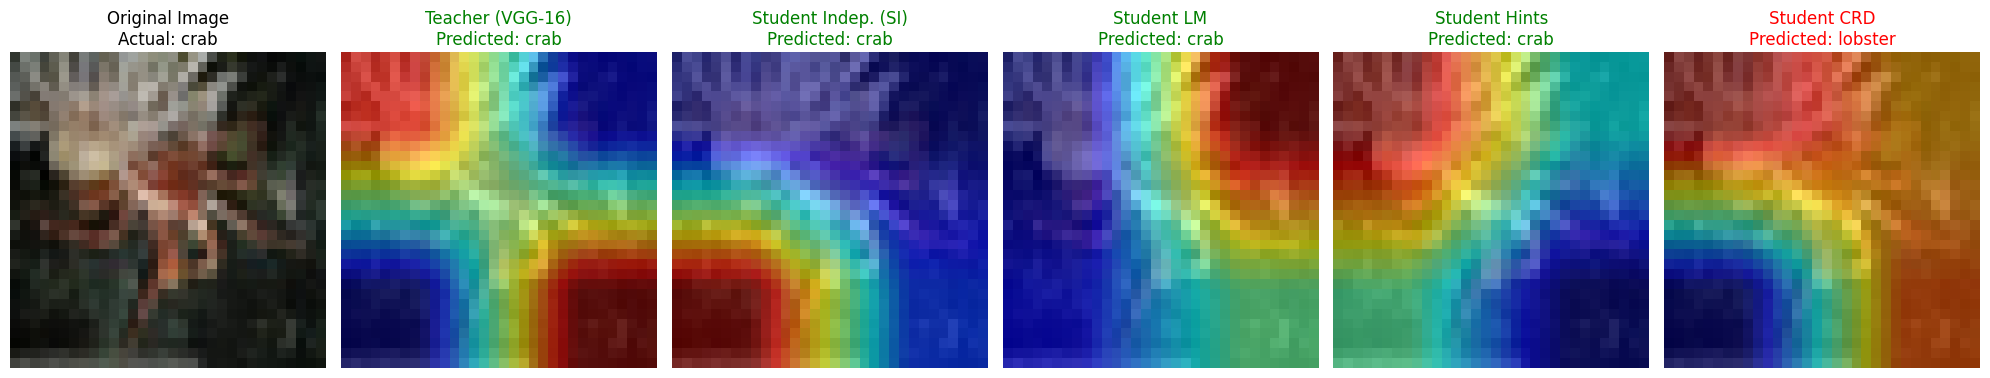

In [ ]:

from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)


!pip install grad-cam -q


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11, vgg16
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

try:
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    cifar100_classes = testset.classes
except Exception as e:
    print(f"Could not load CIFAR-100 dataset. Error: {e}")
    exit()



def create_vgg_model(arch='vgg11', model_type='standard'):
    if arch == 'vgg11':
        model = vgg11(weights=None)
    elif arch == 'vgg16':
        model = vgg16(weights=None)
    else:
        raise ValueError("Architecture must be 'vgg11' or 'vgg16'")

    if model_type == 'standard':
        model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 100),
        )
    elif model_type == 'crd_student':
        model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        model.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 100),
        )
    return model

def imshow(img_tensor):
    img = img_tensor.clone()
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


def generate_grad_cam_visualizations(models_dict, model_order, target_image_tensor, original_image_np, actual_label):
    num_models = len(models_dict)
    fig, axs = plt.subplots(1, num_models + 1, figsize=(20, 5))
    axs[0].imshow(original_image_np)
    axs[0].set_title(f'Original Image\nActual: {actual_label}')
    axs[0].axis('off')
    for i, model_name in enumerate(model_order):
        plot_index = i + 1
        model = models_dict.get(model_name)
        if model is None:
            axs[plot_index].text(0.5, 0.5, f'{model_name}\n(Failed to load)', ha='center', va='center', fontsize=9, color='red')
            axs[plot_index].axis('off')
            continue
        model.eval()
        target_layers = [model.features[-2]]

        cam = GradCAM(model=model, target_layers=target_layers)

        output = model(target_image_tensor.to(device))
        _, predicted_idx = torch.max(output, 1)
        predicted_label = cifar100_classes[predicted_idx.item()]
        targets = [ClassifierOutputTarget(predicted_idx.item())]
        grayscale_cam = cam(input_tensor=target_image_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
        title_color = 'green' if predicted_label == actual_label else 'red'
        axs[plot_index].imshow(visualization)
        axs[plot_index].set_title(f'{model_name}\nPredicted: {predicted_label}', color=title_color)
        axs[plot_index].axis('off')
    plt.tight_layout()
    plt.savefig("distillation_grad_cam_comparison.png", dpi=300)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


base_path = '/content/drive/MyDrive/ATML-PA3/TASK 3'

models_to_load = [
    {'name': 'Teacher (VGG-16)', 'path': os.path.join(base_path, 'best_teacher_vgg16_cifar100.pth'), 'arch': 'vgg16', 'type': 'standard'},
    {'name': 'Student Indep. (SI)', 'path': os.path.join(base_path, 'best_student_si.pth'), 'arch': 'vgg11', 'type': 'standard'},
    {'name': 'Student LM', 'path': os.path.join(base_path, 'best_student_lm.pth'), 'arch': 'vgg11', 'type': 'standard'},
    {'name': 'Student Hints', 'path': os.path.join(base_path, 'best_student_hints.pth'), 'arch': 'vgg11', 'type': 'standard'},
    {'name': 'Student CRD', 'path': os.path.join(base_path, 'best_student_crd.pth'), 'arch': 'vgg11', 'type': 'crd_student'}
]
model_order = [info['name'] for info in models_to_load]


loaded_models = {}
for model_info in models_to_load:
    name, path, arch, m_type = model_info['name'], model_info['path'], model_info['arch'], model_info['type']
    if not os.path.exists(path):
        print(f"Warning: Model file not found at '{path}'. Skipping '{name}'.")
        loaded_models[name] = None
        continue
    try:
        model = create_vgg_model(arch=arch, model_type=m_type)
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        loaded_models[name] = model
        print(f"Successfully loaded '{name}' from '{path}'")
    except Exception as e:
        print(f"Error loading model '{name}' from '{path}': {e}")
        loaded_models[name] = None


image_index_to_test = 100
input_tensor, label_index = testset[image_index_to_test]
input_tensor = input_tensor.unsqueeze(0)
original_image_np = imshow(testset[image_index_to_test][0])
actual_label_name = cifar100_classes[label_index]

print(f"\nGenerating Grad-CAM for image index {image_index_to_test} (Actual Class: {actual_label_name})")


generate_grad_cam_visualizations(
    models_dict=loaded_models,
    model_order=model_order,
    target_image_tensor=input_tensor,
    original_image_np=original_image_np,
    actual_label=actual_label_name
)